# Multilayer Perceptron

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import preprocessing # LabelEncoder
from sklearn.preprocessing import MinMaxScaler # Escala los datos
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
import scikitplot as skplt 
from string import ascii_uppercase 
# import seaborn as sns
import qgrid
import time
#from sklearn.externals import joblib # Para guardar el modelo
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy import stats #Para la moda
## Gráfica tabla
from tempfile import TemporaryDirectory

import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve

from sklearn.neural_network import MLPClassifier

In [2]:
def loadModel(name):    
    path = "../../Models/" + name + ".pkl"
    clf = joblib.load(path)
    
    return clf;

In [3]:
def saveModel(clf, name):
    path = "../../Models/" + name + ".pkl"
    joblib.dump(clf, path) 

In [4]:
def loadCSV(pathSamples, pathMatrix):
    df_loaded = pd.read_table(pathMatrix, sep=',')
    data = pd.read_table(pathSamples, sep=',')
    clin_trial_values = df_loaded.values
    
    Y = data['Eligible']
    Y = Y.astype(int)
    X = clin_trial_values[:, :]
    
    return X, Y;

In [5]:
def loadHD5(name):
    path = '../../Tables/'
    path += name + '.h5'
    return pd.read_hdf(path, 'df').values

In [6]:
def plot_roc(Xtest, Ytest, probs, xlabel):
    ns_probs = [0 for _ in range(len(Ytest))]
    
    probs = probs[:, 1]
    ns_auc = roc_auc_score(Ytest, ns_probs)
    auc = roc_auc_score(Ytest, probs)  

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (auc))

    ns_fpr, ns_tpr, _ = roc_curve(Ytest, ns_probs)
    fpr, tpr, _ = roc_curve(Ytest, probs)   

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= xlabel)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [7]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring='f1',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [8]:
def model_MLP(nCO, nPC, activation='tanh', impresion=True, alpha=0.0001, classifier=None, solver='adam'):
    if classifier is not None:
        mlp = classifier
    else:
        if(nCO == 1):
            mlp = MLPClassifier(activation=activation,max_iter = 1000,hidden_layer_sizes=(nPC), alpha=alpha, solver=solver)
        else:
            layers = tuple((nPC for i in range(nCO)))
            mlp = MLPClassifier(activation=activation,max_iter = 1000,hidden_layer_sizes=layers, alpha=alpha, solver=solver)
        
    tiempo_i = time.time()
    
    accuracy_list = np.zeros([5,2])
    accuracy_list_train = np.zeros([5,2])
    precision_list = np.zeros([5,2])
    precision_list_train = np.zeros([5,2])
    recall_list = np.zeros([5,2])
    recall_list_train = np.zeros([5,2])
    error = np.zeros([5,2])
    error_train = np.zeros([5,2])
    f_list = np.zeros([5,2]) 
    f1_train = np.zeros([5,2])
    
    skf = StratifiedKFold(n_splits=5)
    
    for i, indexes in enumerate(skf.split(X, Y)):
        #Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=.2) # Modificar metodología de validación
        #scaler = MinMaxScaler() #Escala entre 0 y 1
        #Xtrain = scaler.fit_transform(Xtrain)
        #Xtest = scaler.transform(Xtest)
        
        Xtrain, Xtest = X[indexes[0]], X[indexes[1]]
        Ytrain, Ytest = Y[indexes[0]], Y[indexes[1]]

        #if classifier is None:
        #    mlp.fit(Xtrain, Ytrain)
        mlp.fit(Xtrain, Ytrain)    
            
        pred = mlp.predict(Xtest)
        pred_train = mlp.predict(Xtrain)
        
        # accuracy
        _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
        accuracy_list[i] = _accuracy_

        _accuracy_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
        accuracy_list_train[i] = _accuracy_train_

        # recall 
        _recalls_ = recall_score(Ytest, pred, average=None)
        recall_list[i] = _recalls_
        
        _recalls_train_ = accuracy_score(Ytrain, pred_train, normalize=True)
        recall_list_train[i] = _recalls_train_

        # precision 
        _precisions_ = precision_score(Ytest, pred, average=None)
        precision_list[i] = _precisions_
        
        _precisions_train_ = precision_score(Ytrain, pred_train, average=None)
        precision_list_train[i] = _precisions_train_
        
        # f1
        _f_score_ = f1_score(Ytest, pred, average=None)
        f_list[i] = _f_score_
        
        _f_score_train = f1_score(Ytrain, pred_train, average=None)
        f1_train[i] = _f_score_train
        
        # MAE
          
    if impresion:    
        #Curva ROC
        mlp_probs = mlp.predict_proba(Xtest)
        plot_roc(Xtest, Ytest, mlp_probs, "MLP")

        # Matriz Confusion
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)
        
        report = {
            'f1':[np.around(np.mean(f1_train), decimals=5), np.around(np.std(f1_train), decimals=5), np.around(np.mean(f_list), decimals=5), np.around(np.std(f_list), decimals=5)],
            'accuracy':[np.around(np.mean(accuracy_list_train), decimals=5), np.around(np.std(accuracy_list_train), decimals=5), np.around(np.mean(accuracy_list), decimals=5), np.around(np.std(accuracy_list), decimals=5)],
            'precision':[np.around(np.mean(precision_list_train), decimals=5), np.around(np.std(precision_list_train), decimals=5), np.around(np.mean(precision_list), decimals=5), np.around(np.std(precision_list), decimals=5)],
            'recall':[np.around(np.mean(recall_list_train), decimals=5), np.around(np.std(recall_list_train), decimals=5), np.around(np.mean(recall_list), decimals=5), np.around(np.std(recall_list), decimals=5)]
        }

        print(pd.DataFrame.from_dict(report, orient='index', columns=['Training score', '+/-', 'Test score', '+/-']))

        print("Total time:", time.time()-tiempo_i)

    return np.mean(f1_train), np.std(f1_train), np.mean(f_list), np.std(f_list), time.time()-tiempo_i;

In [9]:
def grid_search(parameters):
    mlp = MLPClassifier()
    clf = GridSearchCV(mlp, parameters, scoring='f1', n_jobs=-1, return_train_score=True)
    clf.fit(X,Y)
    
    return clf

# LSA 10k_1Col_NoCarEsp

In [ ]:
loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1200.csv") #Cargar SCV

In [ ]:
model_MLP()

In [ ]:
parameters = {'C':[.1, .5, 1], 'gamma':['auto', .1, .5, 1]}


## LSA, 10k, sin caracteres especiales, 1500 Tópicos

Latent Semantic Analysis con 10mil muestras. Uniendo las columnas "Diagnoses" e "Interventions". Eliminando todos los caracteres especiales y números de las muestras. 1500 tópicos.

In [10]:
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.813


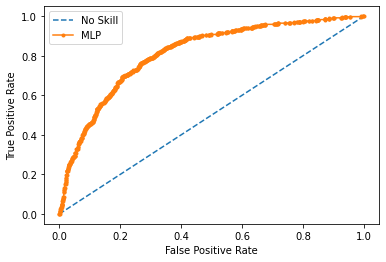

           Training score      +/-  Test score      +/-
f1                  0.998  0.00099     0.74595  0.01074
accuracy            0.998  0.00099     0.74600  0.01014
precision           0.998  0.00166     0.74619  0.01228
recall              0.998  0.00099     0.74600  0.01725
Total time: 113.94111728668213


(0.9979999937030755,
 0.0009937514689830943,
 0.7459506875086604,
 0.010735640010238858,
 113.94111728668213)

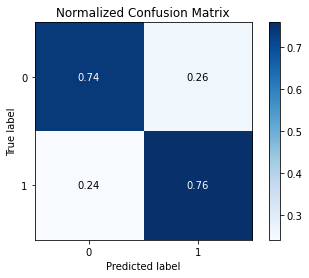

In [18]:
model_MLP(3,20)

In [11]:
parameters = {
    'hidden_layer_sizes' : [[20],[30],[40],[50],[100],
                           [20,20],[30,30],[40,40],[50,50],[100,100],
                           [20,100,20],[30,100,30],[40,100,40],[50,100,50],[100,50,100]],
    'solver' : ['sgd', 'adam'],
    'activation' : ['tanh', 'relu']
}

gs = grid_search(parameters)

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [12]:
saveModel(gs, 'GS_MLP_LSA_1500')

In [15]:
gs = loadModel('MLP_GS_LSA_1500')

In [17]:
gs.best_params_

{'activation': 'relu', 'hidden_layer_sizes': [100, 100], 'solver': 'sgd'}

In [15]:
gs.cv_results_

{'mean_fit_time': array([159.79569674, 167.15295162, 183.60146594, 207.47657142,
        215.16096087, 249.2536128 , 275.25367856, 325.34497871,
        514.08582296, 665.69849677, 163.50858722, 168.8088213 ,
        196.54264174, 178.86863074, 240.04951162, 181.05126128,
        282.261831  , 191.73577905, 541.5311058 , 343.40886083,
        178.90303106,  99.50812387, 214.4142786 , 107.53785481,
        256.8085197 , 130.24243894, 292.7019249 , 156.72382936,
        514.75319834, 261.16806073, 147.08730388, 159.94911318,
        182.35061526, 187.05104108, 215.15549731, 203.54354696,
        258.38410559, 227.93571744, 475.14510245, 379.27605066,
        150.83747416,  66.160291  , 183.1071909 ,  79.63905067,
        222.00358195,  77.95076585, 258.86695175,  97.86789346,
        521.18240423, 161.2891263 , 180.45621209,  56.89364381,
        220.96975069,  69.99413276, 241.82365651,  65.23774886,
        282.61461506,  71.00010843, 443.78480754, 124.19092484]),
 'std_fit_time': arra

In [78]:
results = {}

for i, params in enumerate(gs.cv_results_['params']):
    results[i] = [params['activation'], 
                  params['hidden_layer_sizes'], 
                  params['solver'], 
                  gs.cv_results_['mean_train_score'][i],
                  gs.cv_results_['std_train_score'][i],                  
                  gs.cv_results_['mean_test_score'][i],
                  gs.cv_results_['std_test_score'][i]
                 ]

df = pd.DataFrame.from_dict(results, orient='index', columns=['Activation', 'hidden_layer_sizes', 'solver', 'Training score', '+/-', 'Test score', '+/-'])
    
df.set_index('Activation', inplace=True)
df

,hidden_layer_sizes,solver,Training score,+/-,Test score,+/-
Activation,,,,,,
tanh,[20],sgd,0.829324,0.002809,0.786419,0.011456
tanh,[20],adam,0.998550,0.000187,0.779797,0.009030
tanh,[30],sgd,0.831733,0.003001,0.787483,0.007495
tanh,[30],adam,0.999175,0.000218,0.776427,0.007817
tanh,[40],sgd,0.829512,0.002872,0.788576,0.010015
tanh,[40],adam,0.999325,0.000170,0.779501,0.009812
tanh,[50],sgd,0.831243,0.004409,0.788691,0.008933
tanh,[50],adam,0.999450,0.000100,0.779254,0.008967
tanh,[100],sgd,0.831342,0.003539,0.788204,0.008542


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.964


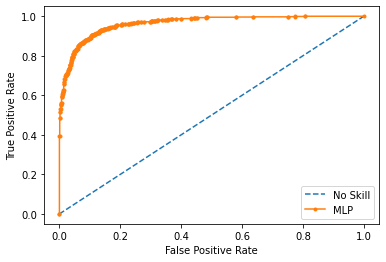

           Training score      +/-  Test score      +/-
f1                0.89280  0.00198     0.89280  0.00756
accuracy          0.89280  0.00188     0.89280  0.00753
precision         0.89285  0.00483     0.89286  0.00910
recall            0.89280  0.00188     0.89280  0.00985
Total time: 3.1138696670532227


(0.8927965885110962,
 0.001977490132301766,
 0.8927958859837885,
 0.007559400367000485,
 3.1138696670532227)

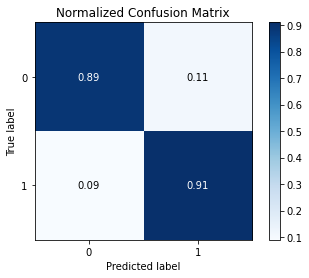

In [16]:
model_MLP(0,0,classifier=gs)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.737


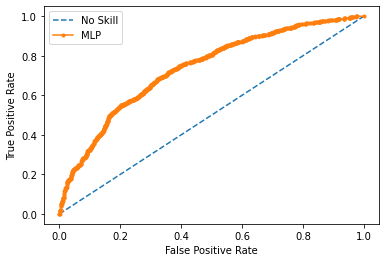

           Training score      +/-  Test score      +/-
f1                0.67606  0.05051     0.66394  0.05358
accuracy          0.68190  0.01744     0.67040  0.01707
precision         0.69476  0.04991     0.68328  0.04832
recall            0.68190  0.01744     0.67040  0.13533
Total time: 2974.380010843277


(0.6760576429165082,
 0.05051165532891921,
 0.6639412311169848,
 0.05357622277843823,
 2974.380010843277)

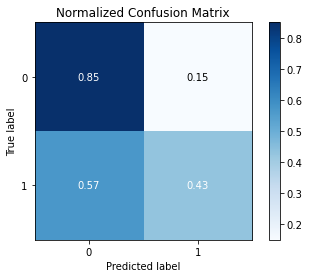

In [31]:
model_MLP(0,0,classifier=gs)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.863


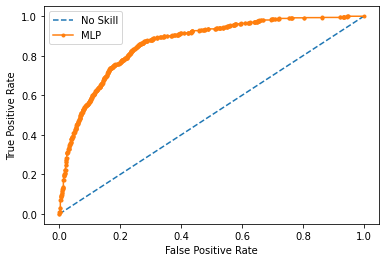

           Training score      +/-  Test score      +/-
f1                 0.9992  0.00019     0.78688  0.00879
accuracy           0.9992  0.00019     0.78690  0.00851
precision          0.9992  0.00048     0.78703  0.01053
recall             0.9992  0.00019     0.78690  0.01358
Total time: 3100.5734584331512


(0.9991999998148439,
 0.0001870835041879618,
 0.7868764465210798,
 0.008790070834953829,
 3100.5734584331512)

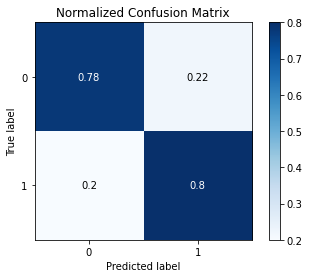

In [17]:
model_MLP(2,100,activation='relu', solver='sgd')

<module 'matplotlib.pyplot' from 'C:\\Users\\Juan José\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

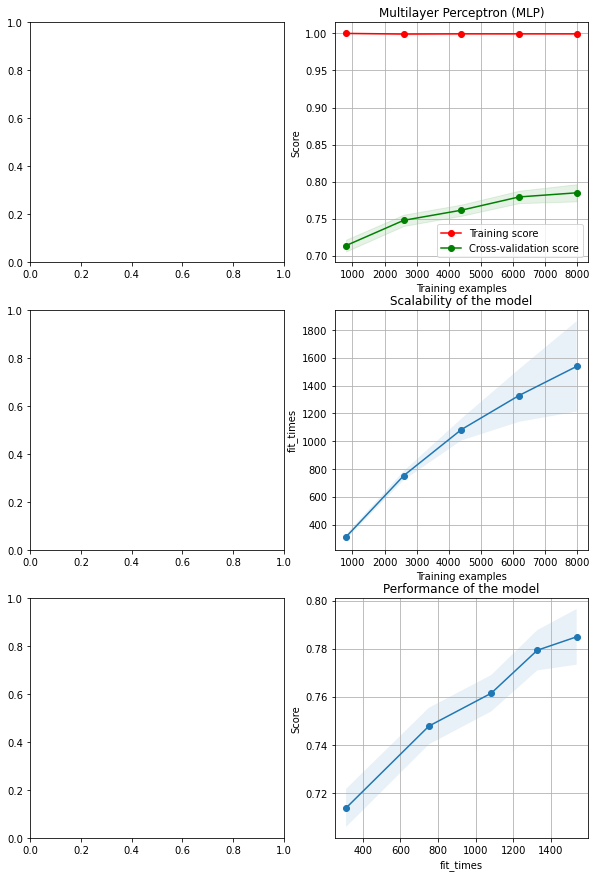

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

mlp = MLPClassifier(activation='relu',max_iter=2000,hidden_layer_sizes=[100,100], solver='sgd')

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

title = "Multilayer Perceptron (MLP)"

plot_learning_curve(mlp, title, X, Y, axes=axes[:, 1], cv=cv, n_jobs=-1)

### Reduced features

#### Chi2 - 100 features

In [20]:
X = loadHD5('FS_Chi2_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.831


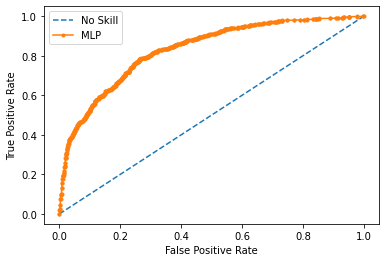

           Training score      +/-  Test score      +/-
f1                0.76588  0.01093     0.75901  0.01532
accuracy          0.76637  0.00134     0.75960  0.00905
precision         0.76866  0.02480     0.76210  0.02666
recall            0.76637  0.00134     0.75960  0.04989
Total time: 109.49565577507019


(0.7658762601440279,
 0.010926501229771428,
 0.7590070699944845,
 0.01531849758316237,
 109.4966516494751)

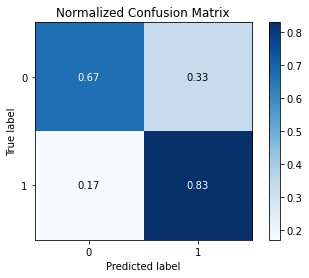

In [24]:
model_MLP(2,100,activation='relu', solver='sgd')

#### F-value - 100

In [25]:
X = loadHD5('FS_Fisher_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.838


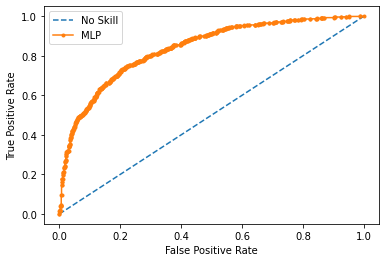

           Training score      +/-  Test score      +/-
f1                0.76411  0.01269     0.75679  0.01360
accuracy          0.76460  0.00574     0.75720  0.00913
precision         0.76673  0.02393     0.75892  0.02306
recall            0.76460  0.00574     0.75720  0.04174
Total time: 117.36916494369507


(0.7641059751404626,
 0.012694058914904766,
 0.7567929938707827,
 0.01360102886147857,
 117.36916494369507)

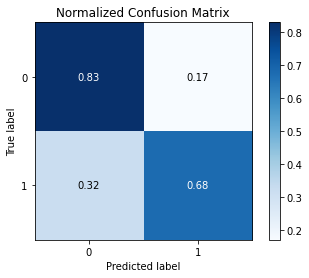

In [26]:
model_MLP(2,100,activation='relu', solver='sgd')

#### Mutual Information - 100

In [27]:
X = loadHD5('FS_Mutual_Information_100')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.741


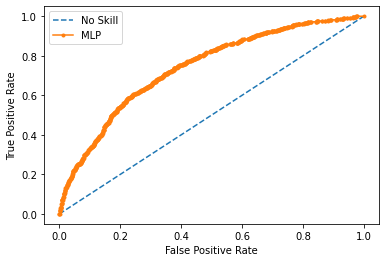

           Training score      +/-  Test score      +/-
f1                0.69101  0.01118     0.67750  0.01506
accuracy          0.69140  0.00185     0.67780  0.01130
precision         0.69236  0.01368     0.67844  0.01543
recall            0.69140  0.00185     0.67780  0.03229
Total time: 160.18791508674622


(0.6910106093311044,
 0.011175654033254377,
 0.6775020977042328,
 0.01506430250190932,
 160.18791508674622)

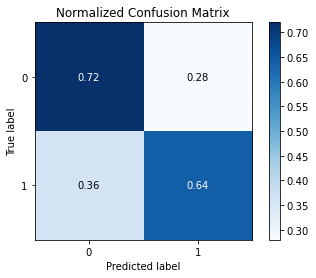

In [29]:
model_MLP(2,100,activation='relu', solver='sgd')

#### LDA

In [11]:
X = loadHD5('LDA_LSA_1500')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.932


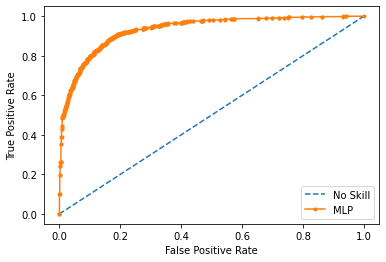

           Training score      +/-  Test score      +/-
f1                0.85287  0.00231     0.85279  0.00764
accuracy          0.85288  0.00200     0.85280  0.00748
precision         0.85296  0.00597     0.85293  0.00997
recall            0.85288  0.00200     0.85280  0.01219
Total time: 11.107676982879639


(0.852865844738855,
 0.0023064400012579346,
 0.852785845637108,
 0.007635558796928657,
 11.107676982879639)

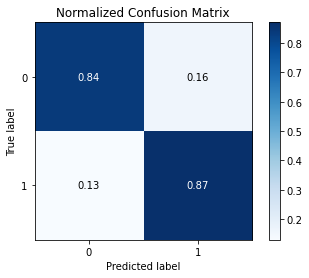

In [12]:
model_MLP(2,100,activation='relu', solver='sgd')

#### PCA - 700

In [13]:
X = loadHD5('PCA_LSA_1500_700')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.863


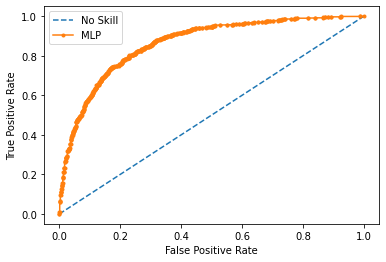

           Training score      +/-  Test score      +/-
f1                 0.9988  0.00019     0.78568  0.01117
accuracy           0.9988  0.00019     0.78570  0.01100
precision          0.9988  0.00079     0.78579  0.01206
recall             0.9988  0.00019     0.78570  0.01408
Total time: 1184.9453575611115


(0.9987999992124992,
 0.00018708632450322097,
 0.785683253113555,
 0.011170854367524734,
 1184.9463543891907)

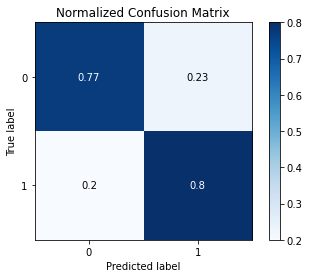

In [14]:
model_MLP(2,100,activation='relu', solver='sgd')

#### SFS (Wrapper) - 100

In [11]:
sfs = loadModel('SFS_100_LSA_1500')
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV
X = X[:,sfs.k_feature_idx_]

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_it

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.783


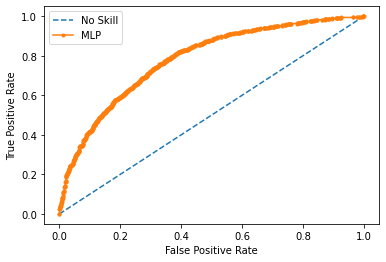

           Training score      +/-  Test score      +/-
f1                0.84323  0.00684     0.71338  0.01123
accuracy          0.84328  0.00632     0.71350  0.00957
precision         0.84369  0.01369     0.71387  0.01318
recall            0.84328  0.00632     0.71350  0.02285
Total time: 548.4940202236176


(0.8432285917499845,
 0.006841882695810094,
 0.7133773503397529,
 0.011226919282593234,
 548.4940202236176)

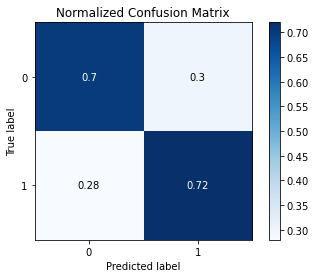

In [12]:
model_MLP(2,100,activation='relu', solver='sgd')

#### SFFS (Wrapper) - 100

In [13]:
sffs = loadModel('SFFS_100_LSA_1500')
X, Y = loadCSV("../../Dataset/10k_1Col_NoCarEsp_LSA.csv", "../../Tables/docsTopicsLSA1500.csv") #Cargar SCV
X = X[:,sffs.k_feature_idx_]

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GaussianNB from version 0.23.1 when using version 0.23.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_it

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.808


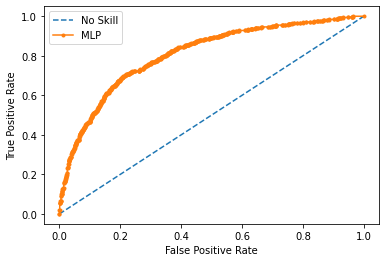

           Training score      +/-  Test score      +/-
f1                0.89942  0.00909     0.72806  0.01263
accuracy          0.89942  0.00906     0.72810  0.01218
precision         0.89950  0.01053     0.72826  0.01372
recall            0.89942  0.00906     0.72810  0.01782
Total time: 508.0795476436615


(0.8994204764249076,
 0.009088791142896126,
 0.728055069450052,
 0.012632220815186552,
 508.07965087890625)

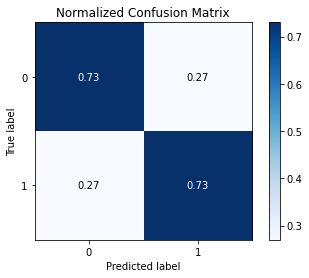

In [14]:
model_MLP(2,100,activation='relu', solver='sgd')

#### Pearson correlation coefficient - 101

In [15]:
X = loadHD5('PEARSON_LSA_1500_100')

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Public\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_it

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.789


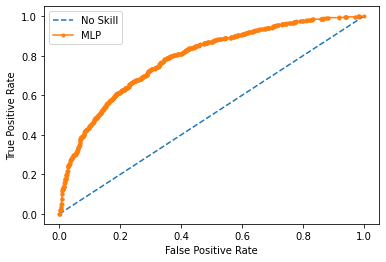

           Training score      +/-  Test score      +/-
f1                0.91721  0.00576     0.71821  0.00914
accuracy          0.91722  0.00566     0.71830  0.00750
precision         0.91757  0.01348     0.71857  0.01049
recall            0.91722  0.00566     0.71830  0.01928
Total time: 453.0084009170532


(0.9172089431417326,
 0.005759205305491363,
 0.7182091436052339,
 0.009144187650571088,
 453.0085189342499)

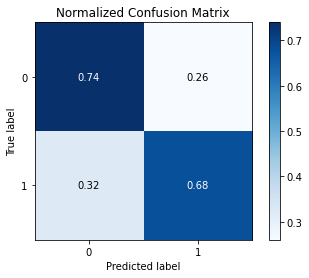

In [16]:
model_MLP(2,100,activation='relu', solver='sgd')